In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import datetime

In [2]:
data = np.load('masked.npz')

In [3]:
training_data = data['training_data']
training_data.shape

(1792, 586507)

In [4]:
df = pd.DataFrame(data['covars'], columns=data['keys'])
print(df.shape)
df.head()

(1792, 5)


,PAC_ID,Label,Age,Gender,TIV
0,PAC2018_0001,1,56,1,1793
1,PAC2018_0002,1,21,1,1565.05
2,PAC2018_0004,1,33,2,1525
3,PAC2018_0005,1,33,1,1800
4,PAC2018_0006,1,61,2,1433.96


In [5]:
df_sites = pd.read_csv('PAC2018_Sites.csv')
dfs = pd.concat((df, df_sites['Scanner']), axis=1)
dfs.head()

,PAC_ID,Label,Age,Gender,TIV,Scanner
0,PAC2018_0001,1,56,1,1793,2
1,PAC2018_0002,1,21,1,1565.05,1
2,PAC2018_0004,1,33,2,1525,2
3,PAC2018_0005,1,33,1,1800,3
4,PAC2018_0006,1,61,2,1433.96,1


In [6]:
tdata = np.load('masked-test.npz')
test_data = tdata['test_data']
print(test_data.shape)

tdf = pd.DataFrame(tdata['covars'], columns=tdata['keys'])
print(tdf.shape)
tdf.head()

(448, 586507)
(437, 5)


,PAC_ID,Scanner,Age,Gender,TIV
0,PAC2018_0003,2,54,2,1349
1,PAC2018_0007,1,65,2,1456.26
2,PAC2018_0014,2,36,2,1388
3,PAC2018_0022,2,32,1,1544
4,PAC2018_0029,3,30,1,1859


In [7]:
all_tdf = pd.concat((tdf, pd.DataFrame(np.setdiff1d(tdata['subs'], tdf.PAC_ID), 
                                       columns=['PAC_ID'])), 
                    axis=0, sort=True)
print(all_tdf.shape)
all_tdf.head()

(448, 5)


,Age,Gender,PAC_ID,Scanner,TIV
0,54,2,PAC2018_0003,2,1349
1,65,2,PAC2018_0007,1,1456.26
2,36,2,PAC2018_0014,2,1388
3,32,1,PAC2018_0022,2,1544
4,30,1,PAC2018_0029,3,1859


In [8]:
cdata = np.load('train+test_cluster.npz')
clusters = cdata['clusters']

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import (classification_report,roc_auc_score)
from sklearn.ensemble import ExtraTreesClassifier

In [10]:
# replace 1/2 with 0/1
y = (df.Label.values - 1).astype(int)
X = np.hstack((training_data,
               clusters[:len(y)],
               np.linalg.norm(training_data, axis=1)[:, None],
               np.mean(training_data, axis=1)[:, None],
              ))
               #dfs[['Age', 'Gender', 'TIV', 'Scanner']].values.astype(float)))
print(X.shape)

N1=500
N2=1000

clf = Pipeline([#('remove', VarianceThreshold(threshold=0.01)),
                ('select1', SelectFromModel(ExtraTreesClassifier(N1, n_jobs=20, 
                                                                 class_weight="balanced"))),
                ('clf', ExtraTreesClassifier(N2, n_jobs=20, class_weight="balanced")),
                ]) 

sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
predictions = [[],[]]
scores = []
importances = []
for train_index, test_index in sss.split(X, y):
    results = []
    clf.fit(X[train_index], y[train_index])
    outputs = clf.predict(X[test_index])
    scores.append(roc_auc_score(y[test_index], outputs, average='weighted', sample_weight=None))
    print(np.median(scores), len(clf.steps[-1][1].feature_importances_),
          str(datetime.datetime.now()))
    #importances.append(clf.steps[-2][1].inverse_transform(clf.steps[-1][1].feature_importances_[None, :]))
    predictions[0].extend(y[test_index])
    predictions[1].extend(outputs)
scores = np.array(scores)
#importances = np.squeeze(np.array(importances))
auc_val = roc_auc_score(predictions[0], predictions[1], average='weighted', sample_weight=None)
print('ROC_AUC_SCORE:', auc_val)
print('CLASSIFICATION REPORT:\n', classification_report(predictions[0], predictions[1]))

(1792, 586510)
0.6224415204678363 94032 2018-06-02 13:36:15.609520
0.615425565725909 94339 2018-06-02 13:36:41.293059
0.6224415204678363 94169 2018-06-02 13:37:06.872217
0.6206934909738113 94110 2018-06-02 13:37:32.518236
0.6224415204678363 93523 2018-06-02 13:37:58.185150
0.6322066488685483 94762 2018-06-02 13:38:23.994983
0.6224415204678363 94147 2018-06-02 13:38:50.039342
0.6322066488685483 94208 2018-06-02 13:39:15.622848
0.6279398677854056 94165 2018-06-02 13:39:41.057294
0.6349558225273328 94624 2018-06-02 13:40:07.059075
0.6406845919145691 94207 2018-06-02 13:40:32.517668
0.6413281845919145 94576 2018-06-02 13:40:58.179649
0.6406845919145691 93194 2018-06-02 13:41:23.957562
0.6350829519450802 94311 2018-06-02 13:41:49.684436
0.6298944825832699 93793 2018-06-02 13:42:15.362942
0.6327469488939741 94315 2018-06-02 13:42:41.138504
0.6298944825832699 93922 2018-06-02 13:43:06.841063
0.6297911899313502 94188 2018-06-02 13:43:32.377746
0.6296878972794304 94150 2018-06-02 13:43:58.02248

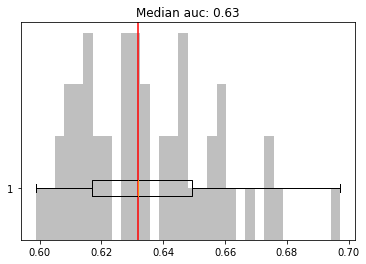

In [11]:
plt.hist(scores, 32, color='gray', alpha=0.5)
plt.axvline(np.median(scores), color='red')
plt.title('Median auc: {:.2f}'.format(np.median(scores)))
ylim = plt.ylim()
#plt.savefig('output.png')
plt.boxplot(scores, vert=False, widths=0.3)
plt.ylim(ylim);
#plt.savefig('output2-maxvote.png')

In [12]:
clf.fit(X, y)

Pipeline(memory=None,
     steps=[('select1', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           ...ators=1000, n_jobs=20, oob_score=False,
           random_state=None, verbose=0, warm_start=False))])

In [13]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf_classify_raw-nocovar.pkl') 

['clf_classify_raw-nocovar.pkl']

In [14]:
clf2 = joblib.load('clf_classify_raw-nocovar.pkl')

In [15]:
Xt = np.hstack((test_data,
                clusters[len(y):],
               np.linalg.norm(test_data, axis=1)[:, None],
               np.mean(test_data, axis=1)[:, None],
               ))
               #tdf[['Age', 'Gender', 'TIV', 'Scanner']].values.astype(float)))

In [16]:
pdf = pd.read_csv('pac_predictions.csv')
print(pdf.shape)
pdf.head()

(448, 2)


,PAC_ID,Prediction
0,PAC2018_0003,1
1,PAC2018_0007,1
2,PAC2018_0014,1
3,PAC2018_0022,1
4,PAC2018_0029,1


In [17]:
# do a max vote - would have done proper boosting, but the computation time was too long
results = []
N = 50
for i in range(N):
    clf.fit(X,y)
    out = clf.predict(Xt)
    results.append(out.tolist())
results = np.array(results)
results.shape

(50, 448)

In [18]:
pdf.Prediction = (np.sum(results, axis=0) > N/2) + 1

In [19]:
pdf.Prediction.value_counts()

1    295
2    153
Name: Prediction, dtype: int64

In [20]:
pdf.to_csv('clf_classify_raw-nocovar-maxvote-output.csv', index=None)

In [21]:
!cat clf_classify_raw-nocovar-maxvote-output.csv

PAC_ID,Prediction
PAC2018_0003,2
PAC2018_0007,1
PAC2018_0014,2
PAC2018_0022,2
PAC2018_0029,1
PAC2018_0033,1
PAC2018_0038,1
PAC2018_0048,1
PAC2018_0051,2
PAC2018_0060,1
PAC2018_0063,1
PAC2018_0064,2
PAC2018_0076,1
PAC2018_0083,1
PAC2018_0085,1
PAC2018_0088,2
PAC2018_0092,2
PAC2018_0101,2
PAC2018_0102,1
PAC2018_0106,2
PAC2018_0107,1
PAC2018_0111,1
PAC2018_0115,1
PAC2018_0135,2
PAC2018_0139,2
PAC2018_0149,2
PAC2018_0154,1
PAC2018_0158,2
PAC2018_0161,2
PAC2018_0163,2
PAC2018_0171,1
PAC2018_0172,2
PAC2018_0174,2
PAC2018_0176,2
PAC2018_0182,1
PAC2018_0183,2
PAC2018_0184,1
PAC2018_0199,2
PAC2018_0203,2
PAC2018_0208,1
PAC2018_0211,2
PAC2018_0212,1
PAC2018_0214,1
PAC2018_0226,1
PAC2018_0239,1
PAC2018_0241,1
PAC2018_0242,1
PAC2018_0243,2
PAC2018_0244,1
PAC2018_0246,1
PAC2018_0248,2
PAC2018_0251,1
PAC2018_0254,2
PAC2018_0260,1
PAC2018_0261,2
PAC2018_0263,2
PAC2018_0266,1
PAC2018_0272,1
PAC2018_0279,2
PAC2018_0287,1
PAC2018_0290,2
PAC2018_0299,1
PAC2018_0301,1
PAC2018_0320,1
PAC2018_0326,1
PAC2018

In [22]:
test = pd.read_csv('submission.csv')
np.sum(test.Prediction != pdf.Prediction)

3